In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'

In [20]:
data_import = pd.read_csv('../Data/SQLout_employees.csv')

In [21]:
data = data_import.query('arrangement == "FT" & year==2018', inplace=False )[['nace', 
                          'esize_class', 'gender', 
                          'age_class', 'lpk',  'education','experience', 'hourly_rate' ]]
data = data.rename(columns={'hourly_rate': 'target'})
data.shape

(36785, 8)

In [22]:
def outlier_iqr_upper(x, n=1.5):
    """ check if x is outlier using IQR"""
    iqr = x.quantile(0.75)-x.quantile(0.25)
    upper_lim = x.quantile(0.75)+iqr*n
    return x>=upper_lim

In [23]:
data['lpk2'] = data['lpk'] // 10
data['outlier'] = data.groupby('lpk2')['target'].apply(outlier_iqr_upper, n=1.0)
data=data.query('outlier==False')
data = data.drop(columns=['outlier', 'lpk2'])
data['lpk'] = data['lpk'].apply(str)

In [24]:
dataset=data.copy()
print(dataset.shape)
dataset.head()

(34259, 8)


,nace,esize_class,gender,age_class,lpk,education,experience,target
44952,C,1_49,M,50-59,722,G2,13,8.13
44953,C,1_49,M,40-49,721,G2,13,8.20
44954,C,1_49,M,50-59,722,G2,13,8.20
44955,C,1_49,F,40-49,334,G2,0,2.51
44956,M,50_249,F,40-49,522,G2,18,2.19


## Datasets

In [25]:
train_dataset = dataset.sample(frac=0.8, random_state=99)
test_dataset = dataset.drop(train_dataset.index)
train_target = train_dataset.pop("target")
test_target = test_dataset.pop("target")

In [26]:
train_ltdu_features_dict = {name: np.array(value) for name, value in train_dataset.items()}
test_ltdu_features_dict = {name: np.array(value) for name, value in test_dataset.items()}

# Feature preprocessing

In [27]:
inputs = {}
for name, column in train_dataset.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'nace': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'nace')>,
 'esize_class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'esize_class')>,
 'gender': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'gender')>,
 'age_class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'age_class')>,
 'lpk': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'lpk')>,
 'education': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
 'experience': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'experience')>}

In [28]:
numeric_inputs = {name:input for name, input in inputs.items()
                  if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(train_dataset[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)


In [29]:
preprocessed_inputs = [all_numeric_inputs]

In [30]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(train_dataset[name]))
  one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

In [31]:
preprocessed_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 19) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'category_encoding_9')>,
 <KerasTensor: shape=(None, 118) dtype=float32 (created by layer 'category_encoding_10')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_11')>]

In [32]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
ltdu_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# Model and predictions

In [33]:
def ltdu_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]),
  return model

ltdu_model = ltdu_model(ltdu_preprocessing, inputs)

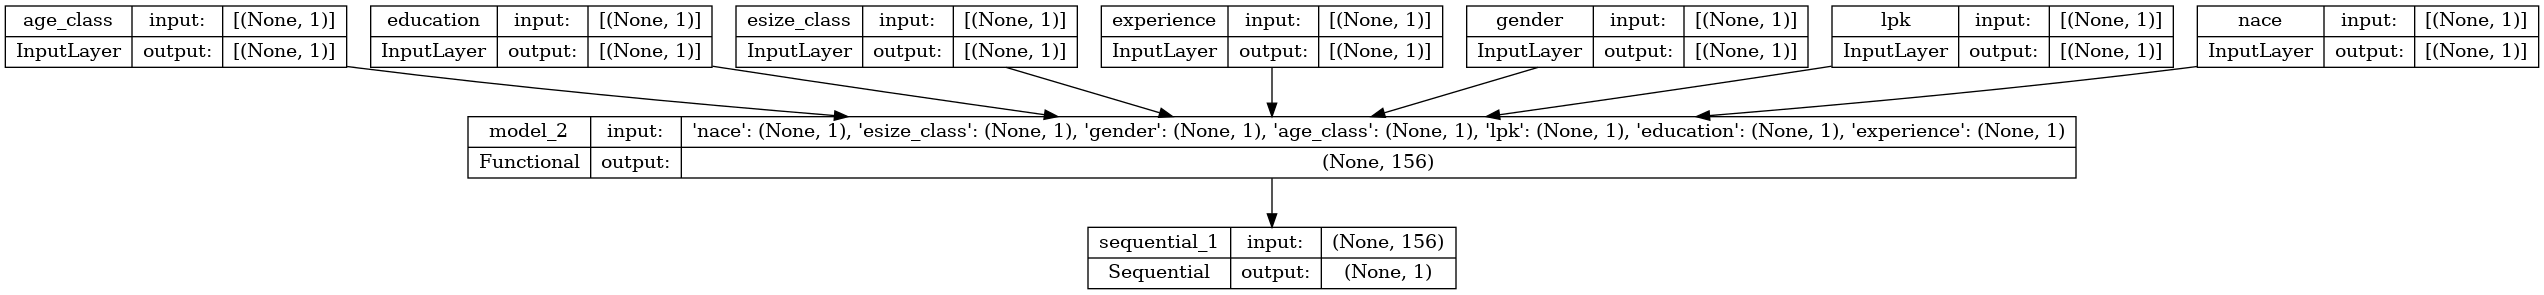

In [34]:
tf.keras.utils.plot_model(ltdu_model, rankdir="TB", show_shapes=True)

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10, 
    restore_best_weights=True,
)

In [36]:
history =ltdu_model.fit(x=train_ltdu_features_dict,
                        y=train_target,
                        epochs=50,
                        validation_split = 0.2,
                        callbacks=[early_stopping])

Epoch 1/50
686/686 [==============================] - 9s 11ms/step - loss: 5.3532 - root_mean_squared_error: 2.3137 - val_loss: 3.3007 - val_root_mean_squared_error: 1.8168
Epoch 2/50
686/686 [==============================] - 7s 10ms/step - loss: 3.6141 - root_mean_squared_error: 1.9011 - val_loss: 3.2156 - val_root_mean_squared_error: 1.7932
Epoch 3/50
686/686 [==============================] - 7s 10ms/step - loss: 3.5233 - root_mean_squared_error: 1.8771 - val_loss: 3.2103 - val_root_mean_squared_error: 1.7917
Epoch 4/50
686/686 [==============================] - 7s 10ms/step - loss: 3.5134 - root_mean_squared_error: 1.8744 - val_loss: 3.1998 - val_root_mean_squared_error: 1.7888
Epoch 5/50
686/686 [==============================] - 7s 10ms/step - loss: 3.4839 - root_mean_squared_error: 1.8665 - val_loss: 3.1832 - val_root_mean_squared_error: 1.7842
Epoch 6/50
686/686 [==============================] - 7s 11ms/step - loss: 3.4752 - root_mean_squared_error: 1.8642 - val_loss: 3.1921 

Minimum validation RMSE: 1.7780945301055908


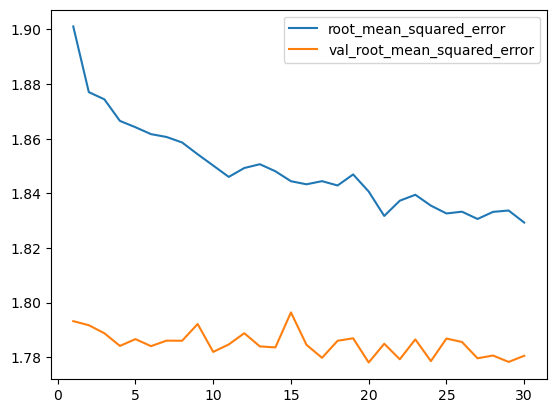

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation RMSE: {}".format(history_df['val_root_mean_squared_error'].min()))

In [38]:
loss, rmse =ltdu_model.evaluate(x=test_ltdu_features_dict, y=test_target)
print("RMSE", rmse)

215/215 [==============================] - 2s 8ms/step - loss: 3.1772 - root_mean_squared_error: 1.7825
RMSE 1.7824798822402954
